In [1]:
import pandas as pd
import MFLibrary as mf
import matplotlib.pyplot as plt
import sqlite3
from run_finder.team_dict_functions import *



In [2]:
teamdict = mf.csv.read_dictionary("team_dictionary/team_dict.csv")

In [3]:
diff3 = pd.read_csv('data/run_calculation_diff3.csv')

In [4]:
conn = sqlite3.connect('C:\Dropbox\Dropbox\HAXz\CBBTO\data\cbb.db')
curr = conn.cursor()
# Exclude unused events - also typo in rebound in a few instances

data = pd.read_sql_query("""SELECT rowid,*
                        FROM playbyplay
                        WHERE LOWER(event) not like '%free throw%'
                        AND LOWER(event) not like '% missed %'
                        AND LOWER(event) not like '%end of %'
                        AND LOWER(event) not like '% reboun%'
                        AND LOWER(event) not like '% steal%'
                        AND LOWER(event) not like '%foul on%'
                        AND gameid not in ('253240066', '253510006', '260692440', '283190221',
                        '283192166', '283190201', '293170264', '283342390', '293172633')""", conn)
conn.close()

data = data.apply(pd.to_numeric,errors='ignore')

In [5]:
data.head(30)

,rowid,gameid,event,team1,team2,score1,score2,time
0,7,253130183,Demetris Nichols made Three Point Jumper.,COR,SYR,0,3,1157
1,29,253130183,Louie McCroskey made Two Point Layup.,COR,SYR,0,5,1036
2,34,253130183,Darryl Watkins made Two Point Layup.,COR,SYR,0,7,988
3,44,253130183,Official TV Timeout.,COR,SYR,2,9,948
4,65,253130183,Adam Gore made Two Point Jumper.,COR,SYR,4,11,814
5,66,253130183,Darryl Watkins made Two Point Jumper.,COR,SYR,4,13,785
6,73,253130183,Lenny Collins made Three Point Jumper.,COR,SYR,7,13,735
7,74,253130183,Official TV Timeout.,COR,SYR,7,13,718
8,75,253130183,Lenny Collins made Three Point Jumper.,COR,SYR,10,13,711
9,76,253130183,Terrence Roberts made Two Point Dunk Shot.,COR,SYR,10,15,659


In [6]:
runs = diff3.loc[(diff3.scorediffdelta > 6) | (diff3.scorediffdelta < -6)]

In [7]:
runs.head()

,Unnamed: 0,rowid,gameid,event,scorediff,time,timedelta,scorediffdelta,normedscorediffdelta
15,23,168,253130183,Ryan Rourke made Two Point Layup.,-2,1068,99.0,7.0,4.242424
22,30,215,253130183,Adam Gore made Three Point Jumper.,4,720,108.0,9.0,5.000000
23,31,227,253130183,Lenny Collins made Three Point Jumper.,5,591,218.0,7.0,1.926606
42,54,405,253120183,Gerry McNamara made Three Point Jumper.,-15,307,364.0,-9.0,-1.483516
46,64,488,253120183,Eric Devendorf made Two Point Layup.,-24,904,276.0,-7.0,-1.521739


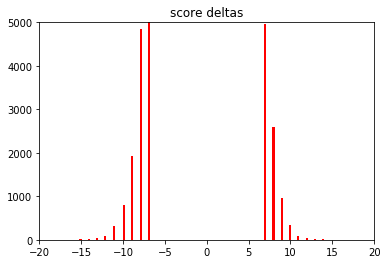

In [8]:
fig = plt.figure()
plt.ylim([0,5000])
plt.xlim([-20,20])
#plt.hist(test['delta1'],bins=20, label='team2')
#plt.hist(test['delta2'], bins=20, color='y', alpha= 0.5, label='team2')
plt.hist(runs['scorediffdelta'], bins=250, color='r', alpha=1, label='diff')
plt.title("score deltas")
plt.show()

In [9]:
runs.describe()

,Unnamed: 0,rowid,gameid,scorediff,time,timedelta,scorediffdelta,normedscorediffdelta
count,25235.000000,2.523500e+04,2.523500e+04,25235.000000,25235.000000,25235.000000,25235.000000,25235.000000
mean,186786.706360,1.168268e+06,3.281171e+08,-6.859560,574.552883,164.815019,-2.304656,-0.929087
std,107466.526435,7.021368e+05,5.550812e+07,14.132513,275.827245,70.719002,7.521763,3.590813
min,23.000000,1.680000e+02,2.531202e+08,-80.000000,91.000000,3.000000,-41.000000,-140.000000
25%,95494.000000,5.534995e+05,2.807603e+08,-15.000000,337.000000,114.000000,-8.000000,-3.414634
50%,185129.000000,1.140644e+06,3.033123e+08,-7.000000,574.000000,151.000000,-7.000000,-2.232558
75%,280829.000000,1.787962e+06,4.005466e+08,3.000000,810.000000,201.000000,7.000000,2.500000
max,373425.000000,2.401448e+06,4.008737e+08,50.000000,1141.000000,1010.000000,21.000000,28.421053


In [10]:
#output = [timeouts - list of callers, caller winning, runstop]

skips = 0
difflength = 3 # This value should extend a little to see if there was a timeout during the development of the run
extraevents = 3
results = []
for i,row in runs.iterrows():
    # continuous runs will show up as new rows in runs.
    # We want to consider each run it's own event, so we skip run events that were accounted for in previous loop
    for n in range(skips):
        continue
    skips = 0
    
    indx = data.loc[data.rowid == row['rowid']].index.values[0]
    runstarttime = row['time']
    working = data.iloc[indx-difflength-extraevents:indx+10] # Grab a few extra events 
    teamlist = [data.iloc[indx]['team1'].strip(), data.iloc[indx]['team2'].strip()]
    print(teamlist)
    timeouts = []
    scorefuture = []
    for j,event in working.iterrows():
        
        # If the slice range crosses a period skip it the incorrect events
        if runstarttime > event['time'] and j < indx:
            continue
                   
        if j == indx - difflength:     
            # if score difference > for team 1 return index 0. If team 2 scores more, return 1
            runnerindex = 0 if data.iloc[indx]['score1'] - event['score1'] > data.iloc[indx]['score2']-event['score2'] else 1
            runner = teamlist[runnerindex]
        
        if event['team1'] not in teamlist:
            print('borked')
            print(event['team1'])
            print(teamlist)
            break
            
        if 'timeout' in event['event'].lower():
            # Check if timeout caller is winning
            caller = determine_TO_caller(event['event'], teamlist, teamdict)
            is_winning = is_caller_winning(teamlist, [event["score1"],event["score2"]], caller)
            # Check if the TO caller is the team that is running (unlikely)
            is_running = caller == runner # TV == False
            timeouts.append([j-indx, caller, is_winning, is_running])
            continue # No scoring occurred so we don't need to finish the loop (prevent duplicates from being added to score future)
            
        if j > indx:
            scorefuture.append([event['score1'],event['score2']])
            # Non-running team scored points (0-1 = -1 == 1 in two item list)
            if scorefuture[-2][runnerindex-1] < scorefuture[-1][runnerindex-1] or event['time']<30:
                break
            else:
                skips += 1
        elif j == indx:
            scorefuture.append([event['score1'],event['score2']])
            
    final = data.loc[(data.gameid == row.gameid)].tail(1)
    winner = teamlist[0 if (final['score1'].values > final['score2'].values) else 1]
    results.append([runner, timeouts, scorefuture, winner])
    if i > 1000:
        break
        
for row in results:
    print(row)

['COR', 'SYR']
['COR', 'SYR']
['COR', 'SYR']
['BCU', 'SYR']
['BCU', 'SYR']
['BU', 'DUKE']
['BU', 'DUKE']
['MEM', 'ALA']
['MEM', 'ALA']
['SAM', 'TEX']
['SAM', 'TEX']
['SAM', 'TEX']
['SAM', 'TEX']
['SAM', 'TEX']
['SAM', 'TEX']
['SAM', 'TEX']
['MSU', 'CHAM']
['MSU', 'CHAM']
['MSU', 'CHAM']
['MSU', 'CHAM']
['MSU', 'CHAM']
['ARIZ', 'KU']
['ARIZ', 'KU']
['ARIZ', 'KU']
['HALL', 'DUKE']
['HALL', 'DUKE']
['HALL', 'DUKE']
['HALL', 'DUKE']
['HALL', 'DUKE']
['HALL', 'DUKE']
['HALL', 'DUKE']
['HALL', 'DUKE']
['HALL', 'DUKE']
['HALL', 'DUKE']
['ULM', 'WVU']
['ULM', 'WVU']
['GONZ', 'MD']
['GONZ', 'MD']
['GONZ', 'MD']
['IOWA', 'UK']
['IOWA', 'UK']
['IOWA', 'UK']
['FAMU', 'IND']
['FAMU', 'IND']
['FAMU', 'IND']
['FAMU', 'IND']
['FAMU', 'IND']
['FAMU', 'IND']
['UCLA', 'DREX']
['UCLA', 'DREX']
['UVA', 'ARIZ']
['UVA', 'ARIZ']
['UVA', 'ARIZ']
['UVA', 'ARIZ']
['UVA', 'ARIZ']
['UVA', 'ARIZ']
['UVA', 'ARIZ']
['IPFW', 'MSU']
['IPFW', 'MSU']
['IPFW', 'MSU']
['NICH', 'MD']
['NICH', 'MD']
['NICH', 'MD']
['NICH', '

In [18]:
print(len(results))
gotonext = False
attemptedstop = []
for row in results:
    print(row)
    if row[1]:
        for to in row[1]:
            if not to[3] and to[1] != 'TV' and to[0]>0: # TO called by slipping team
                attemptedstop.append(row)
                gotonext = True
            if gotonext:
                gotonext = False
                break

print(len(attemptedstop))
print(len(attemptedstop)/len(results))
        
        

93
['COR', [], [[35, 37], [35, 39]], 'SYR']
['COR', [[-6, 'TV', 'TV', False], [-1, 'SYR', False, False], [1, 'COR', True, True]], [[48, 44], [51, 46]], 'SYR']
['COR', [[-3, 'SYR', False, False], [-1, 'COR', True, True]], [[51, 46], [51, 48]], 'SYR']
['SYR', [[-5, 'TV', 'TV', False], [-3, 'SYR', True, True], [1, 'BCU', False, False]], [[10, 25], [12, 25]], 'SYR']
['SYR', [[-1, 'TV', 'TV', False], [1, 'BCU', False, False]], [[20, 44], [22, 44]], 'SYR']
['DUKE', [[1, 'BU', False, False]], [[19, 22], [21, 24]], 'DUKE']
['DUKE', [[-5, 'TV', 'TV', False], [-2, 'TV', 'TV', False], [1, 'BU', False, False]], [[35, 51], [37, 51]], 'DUKE']
['MEM', [], [[10, 5], [11, 7]], 'MEM']
['MEM', [[-6, 'TV', 'TV', False], [-1, 'ALA', False, False]], [[68, 48], [68, 50]], 'MEM']
['TEX', [[-2, 'TV', 'TV', False], [-1, 'TV', 'TV', False], [1, 'SAM', False, False]], [[5, 13], [5, 15], [5, 17], [7, 17]], 'TEX']
['TEX', [[-5, 'TV', 'TV', False], [-4, 'TV', 'TV', False], [-2, 'SAM', False, False]], [[5, 17], [7, 1